C:\Users\dlgus\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\dlgus\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


before
after


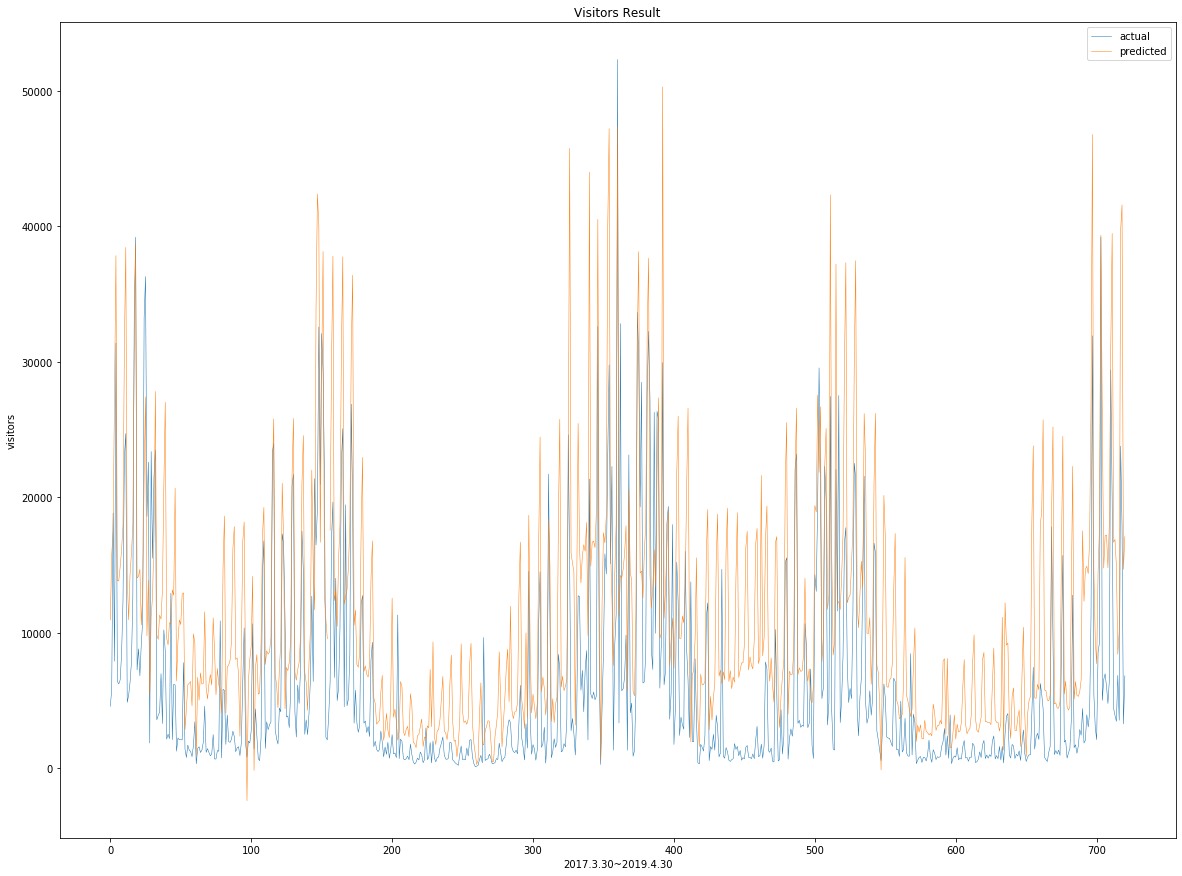

In [14]:
import numpy as np
from keras import layers, models
from keras.utils import np_utils
from keras import optimizers
from keras.optimizers import Adam
from keras.layers import LSTM, Dense, concatenate
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping
import keras.backend as K
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

#***************************파일을 읽고, 날짜 column생성*********************************
df = pd.read_csv('SeoulGrandPark.csv', engine = 'python')    
df["날짜"] = df["년도"].map(str) + '-' +df["월"].map(str) + '-' + df["일"].map(str)
df = df.set_index('날짜')
#**************************train set과 test set분할**************************************
split_date_start = '2017-3-30'
#*****************위는 DNN용 특성 데이터셋, 아래는 LSTM용 시계열 데이터(앞으로도 계속)***
test = df.loc[split_date_start:]
testLSTM = df.loc[split_date_start:, ['일계']]
#**************************데이터를 사용가능하도록 변환**********************************
test['일계'] = test['일계'].str.replace(',', '')
test['일계'] = test['일계'].astype('float')

testLSTM['일계'] = testLSTM['일계'].str.replace(',', '')
testLSTM['일계'] = testLSTM['일계'].astype('float')
#***************************이어서 시계열 데이터만 처리********************************************
#*******************************이제는 일단위 시계열 데이터 처리 (반복)***************************
dayfrom = 14
dayto = 42
day = dayto - dayfrom

sc = MinMaxScaler()
sc.fit([[2],[115002]])
test_scLSTM = sc.transform(testLSTM)

test_sc_dfLSTM = pd.DataFrame(test_scLSTM, columns=['Scaled'], index=testLSTM.index)

for s in range(dayfrom, dayto):
    test_sc_dfLSTM['shift_{}'.format(s)] = test_sc_dfLSTM['Scaled'].shift(s)
    
X_testLSTM = test_sc_dfLSTM.dropna().drop('Scaled', axis=1)
y_testLSTM = test_sc_dfLSTM.dropna()[['Scaled']]
#*****************************일단위 시계열 데이터를 model에 들어갈 수 있게 reshape*****************
X_testLSTM = X_testLSTM.values
y_testLSTM = y_testLSTM.values
X_test_tLSTM = X_testLSTM.reshape(X_testLSTM.shape[0], day, 1)

#********************************이어서 DNN용 특성위주 데이터 정리 및 모델에 맞게 변환****************
test_df = pd.DataFrame(test)
    
X_test = test_df.drop(['일계', '년도', '일'], axis=1)
y_test = test_df[['일계']]

X_test = pd.get_dummies(X_test, columns=['요일', '월'])

sc2 = MinMaxScaler()

sc2.fit([[0, -14.4, -18, -10.7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
[1, 31.8, 28.7, 36.7, 24, 301.5, 1224, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
X_test_sc = sc2.transform(X_test)
sc2.fit([[2],[115002]])
y_test_sc = sc2.transform(y_test)

#모델 로드
from keras.models import load_model
model4 = load_model('thisday1.h5')

X_test_sc_dropped = X_test_sc[dayto-1:]#시계열데이터에 맞게 변환
#**********************************plot을 이용한 그래프 그리기******************************************
print("before")
Y_pred = model4.predict([X_test_tLSTM, X_test_sc_dropped])
print("after")
plt.figure(figsize=(20,15))
plt.rcParams['lines.linewidth'] = 0.5
plt.title('Visitors Result')
plt.xlabel('2017.3.30~2019.4.30')#수정해야 함
plt.ylabel('visitors')
ynewtest = sc.inverse_transform(y_testLSTM)
plt.plot(ynewtest, label='actual')
ynew = sc.inverse_transform(Y_pred)
plt.plot(ynew, label='predicted')
plt.legend()
plt.show()

